In [1]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import os
import pandas as pd
from torchvision.io import read_image
import torchio as tio

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

import nibabel as nib

from models.cnn import cnn3d
from models import (cnn, C3DNet, resnet, ResNetV2, ResNeXt, ResNeXtV2, WideResNet, PreActResNet,
        EfficientNet, DenseNet, ShuffleNet, ShuffleNetV2, SqueezeNet, MobileNet, MobileNetV2)


from IPython.display import clear_output

from my_collate import collate_fn

torch.manual_seed(10)
np.random.seed(10)

/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resnet 모델 정의 

In [19]:
##https://github.com/kenshohara/3D-ResNets-PyTorch/blob/master/models/resnet.py



def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=2):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


class ResNetTwo(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=2):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv3d(self.in_planes*2,
                                self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)   

        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, ct, pet):
        ct = self.conv1(ct)
        ct = self.bn1(ct)
        ct = self.relu(ct)
        if not self.no_max_pool:
            ct = self.maxpool(ct)

        pet = self.conv1(pet)
        pet = self.bn1(pet)
        pet = self.relu(pet)
        if not self.no_max_pool:
            pet = self.maxpool(pet)
        
        x = torch.cat((ct,pet), dim=1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


class Net(nn.Module):

    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.max_pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 16, 5, 1)
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.glob_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class simCNN(torch.nn.Module): 
    def __init__(self, mode="pet"):
        super(simCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv3d(in_channels=8, out_channels=8, kernel_size=3)
        self.conv3 = nn.Conv3d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv4 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3)
        self.glob_avg_pool = nn.AvgPool3d(1,1)
        if mode=="maskpet":
            self.fc1 = nn.Linear(178560, 2)
        elif mode=="petct":
            self.fc1 = nn.Linear(178560, 2)
        elif mode=="pet" or "ct":
            self.fc1 = nn.Linear(178560, 2)
        elif mode=="maskpetct":
            self.fc1 = nn.Linear(178560, 2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool3d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool3d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, start_dim=1)
        #x = self.glob_avg_pool(x)
        #x = torch.cat((x,PCD),dim=1)
        x = self.fc1(x)
        return x
    


In [45]:
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

def generate_modeltwo(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNetTwo(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNetTwo(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNetTwo(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNetTwo(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNetTwo(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNetTwo(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNetTwo(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model


In [3]:
# CUDA device
torch.cuda.is_available()
GPU_NUM = 5
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) 
print ('Current cuda device Number =', torch.cuda.current_device())

if device.type == 'cuda':
    print('Current cuda device Name =', torch.cuda.get_device_name(GPU_NUM))
    print('Current cuda device Memory = {:.2f}GB'.format((torch.cuda.get_device_properties(GPU_NUM).total_memory) * 1e-9))
    
print('Allocated: ', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB', 'Cached:', round(torch.cuda.memory_cached(0)/1024**3/1),'GB')

if torch.cuda.is_available():
    torch.cuda.manual_seed(10)


Current cuda device Number = 5
Current cuda device Name = NVIDIA RTX A6000
Current cuda device Memory = 51.05GB
Allocated:  0.0 GB Cached: 0 GB


/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/torch/cuda/memory.py:397: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [4]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

## Dataset, DataLoader 정의, 선언 

In [20]:
def crop_sample(volume, thr=8):
    #volume[volume < np.max(volume) * 0.1] = 0          # intensity 낮으면 0 (max*0.1 보다 작으면)
    
    # crop xaxial                                      
    v_min, v_max = 0, 0                                        
    for i in range(np.shape(volume)[0]):
        x_axis = volume[i,:,:]
        x_num_nonzero = len(np.where(x_axis>0)[0])
        if x_num_nonzero > 0 and v_min == 0:
            v_min = i
        elif x_num_nonzero > 0 and v_min > 0:
            v_max = i           
    if v_min%thr != 0:
        v_min = v_min-(v_min%thr)
    if v_max%thr != 0:
        v_max = v_max+(thr-(v_max%thr))   
        
    x_min, x_max = v_min, v_max
        
    # crop y-axial
    v_min, v_max = 0, 0
    for j in range(np.shape(volume)[1]):
        y_axis = volume[:,j,:]
        num_nonzero = len(np.where(y_axis>0)[0])
        if num_nonzero > 0 and v_min == 0:
            v_min = j
        elif num_nonzero > 0 and v_min > 0:
            v_max = j
    if v_min%thr != 0:
        v_min = v_min-(v_min%thr)
    if v_max%thr != 0:
        v_max = v_max+(thr-(v_max%thr))
            
    y_min, y_max = v_min, v_max
    
        
    # crop z-axial                                     # z축따라 0 보다 낮은 intensity는 자르기
    v_min, v_max = 0, 0
    for k in range(np.shape(volume)[2]):
        z_axis = volume[:,:,k]      
        num_nonzero = len(np.where(z_axis>0)[0])
        
        if num_nonzero > 0 and v_min == 0:
            v_min = k
        elif num_nonzero > 0 and v_min > 0:
            v_max = k
    
    if v_min%thr != 0:
        v_min = v_min-(v_min%thr)
    if v_max%thr != 0:
        v_max = v_max+(thr-(v_max%thr))
        
    if v_max > np.shape(volume)[2]:
        pad = v_max-np.shape(volume)[2]
        v_max = v_max - pad
        v_min = v_min - pad
        
    if v_min < 0:
        v_min = 6

    if v_max%2==1:
        v_max -= 1
    
    if (v_max-v_min)%thr != 0:
        v_min=4
    if (v_max-v_min)%thr != 0:
        v_min=2
    
    z_min, z_max = v_min, v_max
    
    
    return (
        volume[x_min:x_max,y_min:y_max,z_min:z_max]
    )


def mask_crop(mask, CTvolume, PETvolume):
    for i in range(np.shape(mask)[0]):
        if np.sum(mask[i]) > 0.0:
            x_min = i
            break
    for i in range(np.shape(mask)[0]-1,0,-1):
        if np.sum(mask[i]) > 0.0:
            x_max = i
            break


    for i in range(np.shape(mask)[1]):
        if np.sum(mask[:,i]) > 0.0:
            y_min = i
            break
    for i in range(np.shape(mask)[1]-1,0,-1):
        #print(np.shape(test)[1])
        if np.sum(mask[:,i]) > 0.0:
            y_max = i
            break

    for i in range(np.shape(mask)[2]):
        if np.sum(mask[:,:,i]) > 0.0:
            z_min = i
            break
    for i in range(np.shape(mask)[2]-1,0,-1):
        if np.sum(mask[:,:,i]) > 0.0:
            z_max = i
            break
    
    return (
        mask[x_min:x_max,y_min:y_max,z_min:z_max],
        CTvolume[x_min:x_max,y_min:y_max,z_min:z_max],
        PETvolume[x_min:x_max,y_min:y_max,z_min:z_max]
    )

def flip(mask, CTvolume, PETvolume):

    height, width, depth = mask.shape[0], mask.shape[1], mask.shape[3]
    #Flip
    output = np.zeros((height, width,3), dtype=np.uint8)

    for x in range(height):
        for y in range(width):
            xp = height - x - 1       #상하 반전
            yp = width - y - 1        #좌우 반전
            output[x,y] = img[xp, y] #상하 반전
            # output[x, y] = img[x, yp] #좌우 반전

def normalize_volume(volume):
    nonzero_volume = volume[volume > 0]
    mean = nonzero_volume.mean()
    std  = nonzero_volume.std()
    volume = (volume - mean) / std
    return volume
    



def transform(image, idx, mode='train'):
    # assure the same transformation for both image and target
    subject_dict = {
        'image': tio.ScalarImage(tensor=image),
    }
    
    subject = tio.Subject(subject_dict)
    # A set of transform objects...
    #spatial
    transform_nothing = tio.Lambda(lambda x:x, types_to_apply=None)
    transform_xFlip = tio.RandomFlip(axes=0,flip_probability=1.0)
    transform_yFlip = tio.RandomFlip(axes=1,flip_probability=1.0)
    transform_zFlip = tio.RandomFlip(axes=2,flip_probability=1.0)
    transform_rotation_scale = tio.RandomAffine(scales=(0.95,1.25), degrees=15, image_interpolation='linear',isotropic=True, center='image')
    
    #intensity
    transform_gamma = tio.RandomGamma(log_gamma=(-0.3, 0.3))
    
    # transform 확률
    transforms_dict = {
        transform_nothing: 0.5,
        transform_xFlip: 0.1,
        transform_yFlip: 0.1,
        transform_zFlip: 0.1,
        transform_rotation_scale: 0.1,
        transform_gamma: 0.1
    }
    
    # 여러 transform을 함께 구성
    transforms = tio.OneOf(transforms_dict)

    # augmentaion for only train phase
    assert mode in ["train", "validation", "test"]
    if mode=='train':
        subject = transforms(subject)
        
    return subject['image'].tensor




class PEClassfyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mode="train",K=0,num_folds=5,random_state=11,val_split=0.1):
        assert mode in ["train", "validation", "test"]
        self.img_labels = pd.read_csv(annotations_file, names=['Number', 'key', 'PET date', 'labels name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.PCD_file = pd.read_csv("/nasdata4/kyj0305/PE_study/HY/HY_data/AI_malignanteffusion_20231213_add_disx.csv")
        
        files = []
        volumes = []
        labels = []
        pets = []
        PCDs = []

        subj_weights = np.zeros((len(os.listdir(img_dir)),))



        cnt = 0
        cnt_idx = np.arange(len(os.listdir(img_dir))) # 0, 1, 2, ..., num_subj-1
        kf = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=random_state)
        skf2 =  StratifiedKFold(n_splits=num_folds-1,shuffle=True,random_state=random_state)
        train_indices,validation_indices,test_indices = {},{},{}
        train_y = []
        cnt = 0
        for train_validation_idx, test_idx in kf.split(cnt_idx, np.array(self.img_labels.iloc[1:,4])): 
            for i in train_validation_idx:
                train_y.append(self.img_labels.iloc[i+1,4])
            for train_index, val_index in skf2.split(train_validation_idx, train_y):
                train_indices[str(cnt)], validation_indices[str(cnt)] = train_index, val_index
                test_indices[str(cnt)] = test_idx
            train_y = []
            cnt += 1
        if mode == 'train':
            sel = train_indices[str(K)]
        elif mode == 'validation':
            sel = validation_indices[str(K)]
        elif mode == 'test':
            sel = test_indices[str(K)]
        

        # read image
        print("reading {} images...".format(mode))
        print("The length of {} set is: {}".format(mode, len(sel)))
        cnt = 1
        for (dirpath, dirnames, filenames) in os.walk(img_dir):
            subj_batch = {}
            print(filenames)
            if len(filenames) == 5:

                if np.any(sel==cnt):
                    print('cnt',cnt)
                    subj_num =  self.img_labels.iloc[cnt, 1]
                    label =  int(self.PCD_file.iloc[cnt-1, 4])
                    print(subj_num)
                    print('right or left', self.PCD_file.iloc[cnt-1, 5])
                    #print('canser label', self.PCD_file.iloc[cnt-1, 8])
                    PCD_feature = np.array([int(self.PCD_file.iloc[cnt-1, 5]), int(self.PCD_file.iloc[cnt-1, 8])])

                    if label ==0:
                        label = [1,0]
                    elif label == 1:
                        label = [0,1]
                    files.append(subj_num)
                    subdir = subj_num + "_CT"
 
                    volume_fname = "input.nii"
                    pet_fname = "pet.nii"
                    mask_fname = "new_result.nii.gz"
                    

                    subj_batch['image'] = nib.load(os.path.join(dirpath,volume_fname)).get_fdata()
                    subj_batch['pet'] = nib.load(os.path.join(dirpath,pet_fname)).get_fdata()
                    subj_batch['mask'] = nib.load(os.path.join(dirpath,mask_fname)).get_fdata()
                    
                    #cropping
                    subj_batch['mask'], subj_batch['image'], subj_batch['pet'] = mask_crop(subj_batch['mask'], subj_batch['image'], subj_batch['pet'])
                    
                    volumes.append(subj_batch['image'])
                    pets.append(subj_batch['pet'])
                    labels.append(label)
                    PCDs.append(PCD_feature)
                cnt = cnt + 1
            elif len(filenames) == 4:
                cnt = cnt + 1
            
        
        #padding to make same dimension
        print(files)
        x_max_len = 138
        y_max_len = 61
        z_max_len = 132
        #x_max_len = 201
        #y_max_len = 201
        #z_max_len = 169
        #x_max_len = max([len(i) for i in pets[:]]) + 1
        #y_max_len = max([len(i[0]) for i in pets[:]]) + 1 
        #z_max_len = max([len(i[0][0]) for i in pets[:]]) + 1
        print(z_max_len)
        
        for i in range(len(pets)):
            j, k, l = len(pets[i]), len(pets[i][0]), len(pets[i][0][0])
            print(j, k, l)
            npad = ((0,x_max_len - j),(0,y_max_len - k), (0,z_max_len - l))
            pets[i] = np.pad(pets[i], npad, 'constant', constant_values=0)
            print(pets[i].shape)

        # print and s

        print("Number of volumes {} set is: {}".format(mode, len(volumes)))
        self.volumes = volumes
        self.labels = np.array(labels)
        self.pets = pets
        self.PCDs = PCDs
        print(labels)
        #print("Number of image size {} set is: {}".format(mode, np.shape(self.volumes)))
        
    def __len__(self):
        return len(self.volumes)

    def __getitem__(self, idx):
        print("idx:",idx)
        #image = self.volumes[idx]
        pet = self.pets[idx]
        label = self.labels[idx]
        PCD_feature = self.PCDs[idx]

        #image = torch.from_numpy(image)
        pet = torch.from_numpy(pet)
        label = torch.LongTensor(label)
        PCD_feature = torch.FloatTensor(PCD_feature)

        #image = torch.unsqueeze(image,0)
        pet = torch.unsqueeze(pet,0)
        #print(image.shape)
        print(pet.shape)

        #if self.transform:
        #    image = self.transform(image, idx)

        #sample = {"image": image, "label": label}
        
        return pet, label, PCD_feature

def data_loaders(path,annot,batch_size,K=0):
    dataset_train, dataset_valid, dataset_test = datasets(path,annot, K=K)

    
    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,

    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size*100,
        shuffle=False,
        drop_last=False,
    )
    loader_test = DataLoader(
        dataset_test,
        batch_size=batch_size*100,
        shuffle=False,
        drop_last=False,
    )

    return loader_train, loader_valid, loader_test

def datasets(images,annot, K=0, num_folds=5,random_state=2023,val_split=0.2):
    train = PEClassfyDataset(
        annotations_file=annot,
        img_dir=images,
        mode="train",
        transform=transform,
        K=K,num_folds=num_folds,random_state=random_state,val_split=val_split,
    )
    valid = PEClassfyDataset(
        annotations_file=annot,
        img_dir=images,
        mode="validation",
        transform=None,
        K=K,num_folds=num_folds,random_state=random_state,val_split=val_split,
    )
    test = PEClassfyDataset(
        annotations_file=annot,
        img_dir=images,
        mode="test",
        transform=None,
        K=K,num_folds=num_folds,random_state=random_state,val_split=val_split,
    )
    return train, valid, test


## 모델 학습, 테스트

In [134]:
## 파라미터 설정

lr = 0.00001
decay = 0.01
batch_size= 10
epochs = 100
#criterion = nn.BCELoss
criterion = nn.BCEWithLogitsLoss()
path = '/nasdata4/kyj0305/PE_study/HY/HY_data/effusion'
annot_file = '/nasdata4/kyj0305/PE_study/HY/HY_data/PEstudy_labels.csv'
weights = '/nasdata4/kyj0305/PE_study/HY/weight/'

#model = model = ShuffleNet.get_model(groups=3, num_classes=2, in_channels=1).to(device)
#model = SqueezeNet.get_model( version=1.0, sample_size=112, sample_duration=16, num_classes=2, in_channels=1).to(device)
#model = MobileNet.get_model(sample_size=112, num_classes=2, in_channels=1).to(device)
model = DenseNet.generate_model(model_depth=121,num_classes=2, n_input_channels=1).to(device)
#model = generate_model(101,n_input_channels=1,n_classes=2).to(device)
#model = EfficientNet.EfficientNet3D.from_name('efficientnet-b3', override_params={'num_classes': 2}, in_channels=1).to(device)
#model = ResnetTwo(101,n_input_channels=1,n_classes=2).to(device)
#model = simCNN().to(device)
K=4

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)


/nasdata4/kyj0305/PE_study/model_train/code/models/DenseNet.py:134: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [135]:
loader_train, loader_valid, loader_test = data_loaders(path=path, annot=annot_file, batch_size=batch_size, K=K)
loaders = {"train": loader_train, "valid": loader_valid, "test" : loader_test}

/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated cl

reading train images...
The length of train set is: 72
[]
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 1
H001
right or left 2
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 4
H004
right or left 2
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 5
H005
right or left 1
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 7
H007
right or left 1
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 8
H008
right or left 1
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 10
H010
right 

/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated cl

['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 3
H003
right or left 2
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 9
H009
right or left 1
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'p

/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/home/hoya1212/anaconda3/envs/yj_unet/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated cl

['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 14
H014
right or left 2
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz']
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 17
H017
right or left 1
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_result.nii.gz']
cnt 18
H018
right or left 1
['input.nii', 'pet.nii', 'result.nii', 'masked_pet.nii.gz', 'new_re

idx: 0
torch.Size([1, 138, 61, 132])
idx: 1
torch.Size([1, 138, 61, 132])
idx: 2
torch.Size([1, 138, 61, 132])
idx: 3
torch.Size([1, 138, 61, 132])
idx: 4
torch.Size([1, 138, 61, 132])
idx: 5
torch.Size([1, 138, 61, 132])
idx: 6
torch.Size([1, 138, 61, 132])
idx: 7
torch.Size([1, 138, 61, 132])
idx: 8
torch.Size([1, 138, 61, 132])
idx: 9
torch.Size([1, 138, 61, 132])
idx: 10
torch.Size([1, 138, 61, 132])
idx: 11
torch.Size([1, 138, 61, 132])
idx: 12
torch.Size([1, 138, 61, 132])
idx: 13
torch.Size([1, 138, 61, 132])
idx: 14
torch.Size([1, 138, 61, 132])
idx: 15
torch.Size([1, 138, 61, 132])
idx: 16
torch.Size([1, 138, 61, 132])
idx: 17
torch.Size([1, 138, 61, 132])
idx: 18
torch.Size([1, 138, 61, 132])
idx: 19
torch.Size([1, 138, 61, 132])
idx: 20
torch.Size([1, 138, 61, 132])


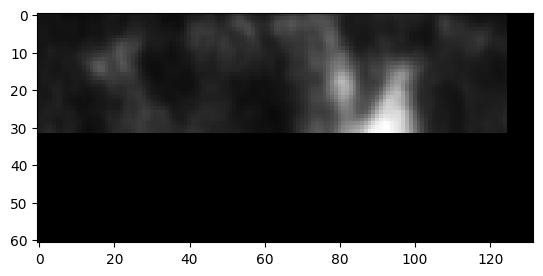

In [138]:
for i, data in enumerate(loader_test):
    pet, y_true,_ = data
    plt.imshow(pet[i,0,10,:,:], cmap='gray')
    plt.show()

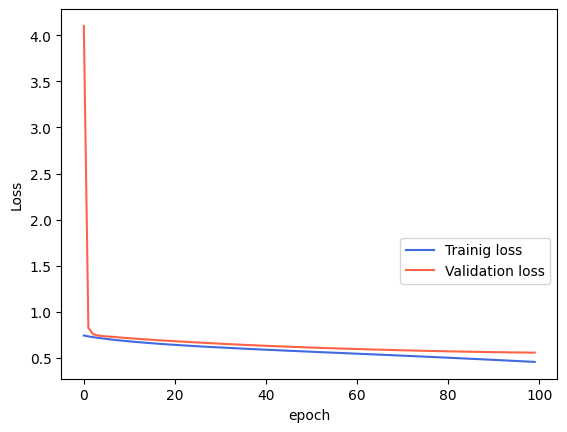

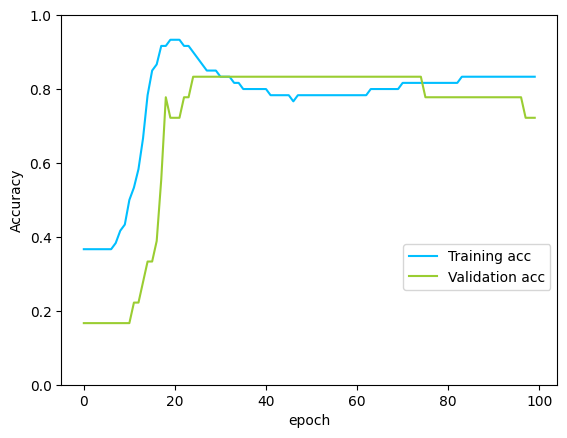


Current Best validation acc: 0.833333

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[-0.27790236  0.43625557]
 [-0.31134945  0.4316989 ]
 [-0.3611107   0.5238308 ]
 [-0.03629271  0.18835181]
 [-0.38000816  0.5387197 ]
 [-0.3668412   0.5712863 ]
 [-0.30675024  0.49129227]
 [-0.30296445  0.43052644]
 [-0.5350037   0.6619699 ]
 [-0.5825925   0.67358613]
 [-0.19650301  0.4140687 ]
 [-0.21697977  0.31934685]
 [-0.37426615  0.5006278 ]
 [-0.30398697  0.41031542]
 [-0.30666247  0.39410812]
 [ 0.04566614  0.05279749]
 [-0.6628465   0.8365831 ]
 [-0.33314243  0.40454155]]

Best validation accurcy: 0.833333


Best validation auc: 0.562222


Best validation sensitivity:  nan


Best validation specificity: 0.833333



In [136]:
torch.manual_seed(0)
np.random.seed(0)

# train and validation procedure
best_validation_dsc = 0.0

loss_train=[]
loss_valid=[]
allloss_train=[]
alldsc_train=[]
allloss_val=[]
alldsc_val=[]
sensitive_list = []
specific_list = []
roc_list=[]
val_auc_list=[]

# actual processing...
step = 0
print("0 Fold")
 
   
for epoch in range(epochs):
    print("epoch", epoch)
    for phase in ["train", "valid"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        train_acc_list=[]
        validation_acc_list=[]


        for i, data in enumerate(loaders[phase]):
            print('done')
            if phase == "train": step += 1
            x, y_true, PCD = data
            print('y_true: ',y_true)
            x, y_true,PCD = x.to(device).float(), y_true.to(device).float(), PCD.to(device).float()
            print("x size: {}".format(x.size()))
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"): 
                y_pred = model(x) # forwarding   
                print('y_pred: ',y_pred)  
                print('y_true: ',y_true) 
                loss = criterion(y_pred, y_true)
                if phase == "train":
                    loss_train.append(loss.item())

                    y_true_cpu = y_true.detach().cpu().numpy()
                    y_pred_cpu = y_pred.detach().cpu().numpy()

                    y_spred = []
                    y_strue = []
                    for i in y_pred_cpu:
                        if i[0] > i[1]: scalar_y_pred = 0
                        else: scalar_y_pred = 1
                        y_spred.append(scalar_y_pred)
                    acc = accuracy_score(y_spred, y_true_cpu[:,1])
                    train_acc_list.append(acc)

                    loss.backward()
                    optimizer.step() # backpropagation

                    #plot_img(x[:,:,:,:,50], y_true[:,:,:,:,50], y_pred[:,:,:,:,50])
                    

                if phase == "valid":
                    loss_valid.append(loss.item()) # gathering the loss
                    
                    y_true_cpu = y_true.detach().cpu().numpy()
                    y_pred_cpu = y_pred.detach().cpu().numpy()

                    y_spred = []
                    y_strue = []
                    for i in y_pred_cpu:
                        if i[0] > i[1]: scalar_y_pred = 0
                        else: scalar_y_pred = 1
                        y_spred.append(scalar_y_pred)
                    acc = accuracy_score(y_spred, y_true_cpu[:,1])

                    for i in range(y_true.shape[1]):
                    #AUC is only defined when there is at least one positive data.
                        roc_list.append(roc_auc_score(y_true_cpu[:,i], y_pred_cpu[:,i]))
                    cm = confusion_matrix(y_spred, y_true_cpu[:,1])

                    print(cm)
                    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
                    sensitive_list.append(sensitivity)
                    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
                    specific_list.append(specificity)
                    validation_acc_list.append(acc)
                    val_auc_list.append(np.mean(np.array(roc_list)))


                    #plot_img(x[:,:,:,:,50], y_true[:,:,:,:,50], y_pred[:,:,:,:,50])


        if phase == "train": # reporting
            print("=================================================")
            print("epoch {} | {}: {}".format(epoch + 1, "Train loss", np.mean(loss_train)))
            print("        | {}: {}".format("Train Dice", np.mean(train_acc_list)))

            allloss_train.append(np.mean(loss_train))
            alldsc_train.append(np.mean(train_acc_list))
            loss_train=[]


        if phase == "valid": #reporting
            print("...................................................")
            print("     | {}: {}".format("Validation loss", np.mean(loss_valid)))
            print("     | {}: {}".format("Validation Dice", np.mean(validation_acc_list)))

            # save best model
            if acc >= best_validation_dsc:
                y_true_f= y_true_cpu
                y_pred_f = y_pred_cpu
                best_auc = np.mean(np.array(roc_list))
                best_sen = sensitivity
                best_spe = specificity
                best_validation_dsc = acc
                torch.save(model.state_dict(), os.path.join(weights+f'CNN_withPCD_mask3dpatch_pet_{K}fold.pth'))
                print("\n save acc : {:4f}\n".format(best_validation_dsc))  

            alldsc_val.append(acc)
            allloss_val.append(np.mean(loss_valid))
            loss_valid=[]

        
        clear_output()
        plt.plot(allloss_train, label='Trainig loss', color='royalblue')
        plt.plot(allloss_val, label='Validation loss', color='tomato')
        plt.legend(bbox_to_anchor=(1,0.4))
        #plt.ylim([0,1])
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.show()

        plt.plot(alldsc_train, label='Training acc', color='deepskyblue')
        plt.plot(alldsc_val, label='Validation acc', color='yellowgreen')
        plt.legend(bbox_to_anchor=(1,0.4))
        plt.ylim([0,1])
        plt.xlabel('epoch')
        plt.ylabel('Accuracy')
        plt.show()
        print("\nCurrent Best validation acc: {:4f}\n".format(best_validation_dsc))
print(y_true_f)
print(y_pred_f)
print("\nBest validation accurcy: {:4f}\n".format(best_validation_dsc))
print("\nBest validation auc: {:4f}\n".format(best_auc))
print("\nBest validation sensitivity: {:4f}\n".format(best_sen))
print("\nBest validation specificity: {:4f}\n".format(best_spe))

In [137]:
#print(y_pred_f)
print("\nBest validation accurcy: {:4f}\n".format(best_validation_dsc))
print("\nBest validation auc: {:4f}\n".format(best_auc))
print("\nBest validation sensitivity: {:4f}\n".format(best_sen))

print("\nBest validation specificity: {:4f}\n".format(best_spe))


Best validation accurcy: 0.833333


Best validation auc: 0.562222


Best validation sensitivity:  nan


Best validation specificity: 0.833333



In [140]:
PATH = weights + "CNN_withPCD_mask3dpatch_pet_3fold.pth"

model.eval()
model.load_state_dict(torch.load(PATH))
test_acc_list=[]



for i, data in enumerate(loader_test):
    print('done')
    #if phase == "train": step += 1
    x, y_true, PCD = data
    x, y_true = x.to(device).float(), y_true.to(device).float()
    optimizer.zero_grad()
    
    y_pred = model(x)              
    y_true_cpu = y_true.detach().cpu().numpy()
    y_pred_cpu = y_pred.detach().cpu().numpy()
    y_spred = []
    y_strue = []
    for i in y_pred_cpu:
        if i[0] > i[1]: scalar_y_pred = 0
        else: scalar_y_pred = 1
        y_spred.append(scalar_y_pred)
    print(y_spred)
    print(y_true_cpu[:,1])
    acc = accuracy_score(y_spred, y_true_cpu[:,1])
    for i in range(y_true.shape[1]):
         #AUC is only defined when there is at least one positive data.
        roc_list.append(roc_auc_score(y_true_cpu[:,i], y_pred_cpu[:,i]))
    cm = confusion_matrix(y_spred, y_true_cpu[:,1])

    print(cm)
    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
   

    test_acc_list.append(acc)
#clear_output()
print('acc: ', acc)
print('auc: ', np.mean(np.array(roc_list)))
print('sen: ', sensitivity)
print('spe: ', specificity)


idx: 0
torch.Size([1, 138, 61, 132])
idx: 1
torch.Size([1, 138, 61, 132])
idx: 2
torch.Size([1, 138, 61, 132])
idx: 3
torch.Size([1, 138, 61, 132])
idx: 4
torch.Size([1, 138, 61, 132])
idx: 5
torch.Size([1, 138, 61, 132])
idx: 6
torch.Size([1, 138, 61, 132])
idx: 7
torch.Size([1, 138, 61, 132])
idx: 8
torch.Size([1, 138, 61, 132])
idx: 9
torch.Size([1, 138, 61, 132])
idx: 10
torch.Size([1, 138, 61, 132])
idx: 11
torch.Size([1, 138, 61, 132])
idx: 12
torch.Size([1, 138, 61, 132])
idx: 13
torch.Size([1, 138, 61, 132])
idx: 14
torch.Size([1, 138, 61, 132])
idx: 15
torch.Size([1, 138, 61, 132])
idx: 16
torch.Size([1, 138, 61, 132])
idx: 17
torch.Size([1, 138, 61, 132])
idx: 18
torch.Size([1, 138, 61, 132])
idx: 19
torch.Size([1, 138, 61, 132])
idx: 20
torch.Size([1, 138, 61, 132])
done
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.]
[[ 4  1]
 [ 4 12]]
acc:  0.7619047619047619
auc:  0.5983754399195576
sen:  0.8